## Predict the orbit of James Webb space telescope with a quantum algorithm - Herman Kolden
### Task 3: Combine quantum teleportation circuit with HHL

Team members:
* Felix Cahyadi
* Luis Reyna
* Mohammed Amlieh
* Göksun Beren
* Abhipsa Acharya
* Akshat Srivastava

General idea:\
We want to teleport a quantum state from a satellite (Alice) to MIT (Bob). MIT will then use the given information to do HHL and predict the next position of the satellite. In this task, we initialize the state in Alice's qubit, and send it to Bob's qubit. The rest is the same as in task 1.

### Import libraries

In [1]:
# Import all necessary libraries
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit import execute
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

### Define helper functions

In [2]:
# This function will help us to create a Bell pair of the first kind
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [3]:
# We entangle one of the Bell pair qubit with Alice's qubit
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [5]:
# Measure Alice's qubits and "send" the classical bits to bob
def measure_and_send(qc, qa, qb, ca, cb):
    qc.barrier()
    qc.measure(qa,ca)
    qc.measure(qb,cb)

In [6]:
# Bob will receive Alice's state, but with some extra rotation to it
# He needs to correct it by applying x and z rotation based on the result of measurements on Alice's qubits
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
    qc.barrier

### The teleportation circuit

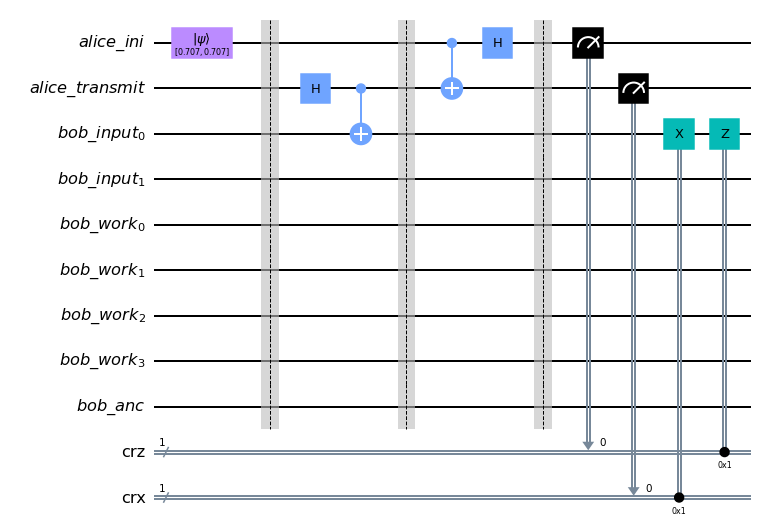

In [7]:
# We'll prepare a state for Alice
# Assume that this is the state that she gets from the quantum measurement

# Make an init gate
theta = np.pi/4 # angle in radians
init_gate = Initialize([np.cos(theta),np.sin(theta)])
init_gate.label = "init"

#create registers for Alice and Bob
qa_in = QuantumRegister(1, name = "alice_ini") # Alice's initial qubit
qa_t = QuantumRegister(1, name = "alice_transmit") # Alice's transmit qubit, We'll entangle it with Bob's input qubit
qb_in = QuantumRegister(2, name = "bob_input") # Bob's input qubits for HHL
qb_work = QuantumRegister(4, name = "bob_work") # Bob's work qubits for HHL
qb_anc = QuantumRegister(1, name = "bob_anc") #Bob's ancilla qubit for HHL
crz = ClassicalRegister(1, name = "crz") # Classical register for teleportation
crx = ClassicalRegister(1, name = "crx")
qc = QuantumCircuit(qa_in,qa_t,qb_in,qb_work,qb_anc,crz,crx) # Create the quantum circuit

## STEP 0
# First, let's initialize Alice's q0
qc.append(Initialize([np.sqrt(1/2),np.sqrt(1/2)]), [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

### Simulate the teleportation

In [9]:
backend = Aer.get_backend('statevector_simulator')
job_result = execute(qc, backend=backend, shots=1, memory=True).result()
dirty_state = job_result.get_statevector(qc).data
print(dirty_state)

[ 0.        +0.00000000e+00j  0.70710678+0.00000000e+00j
  0.        +0.00000000e+00j -0.        +0.00000000e+00j
 -0.        +0.00000000e+00j  0.70710678-8.65956056e-17j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
 -0.        +0.00000000e+00j -0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0

The position of the amplitudes that we care about will change each simulation, that's because we are looking at the output

$$
\ket{0}_{\text{anc}}\otimes\ket{0000}_{\text{work}}\otimes(\ket{0}_{\text{bob 2}}\otimes \ket{\psi}_{\text{bob 1}})\otimes\ket{x}_{\text{alice}}
$$

Bob already get the state from Alice, but Alice's final state will switch between $\ket{00},\ket{01},\ket{10},\ket{11}$ each run. We will use the result from the classical bits to help us retrieve the amplitudes.

In [17]:
# We want to look at the result from the measurement
counts = job_result.get_counts() # Get count from classical bits
meas_bit = list(counts.keys())[0].replace(" ","") # Convert the dictionary to list, get the key (our bits), and remove space in between the bit string
print(meas_bit) # The output should be '00', '01', '10', or '11' string



01


### Helper function
We'll define a helper function find_idx() that outputs the indexes that's interesting to us

In [26]:
def find_idx(lead,variation,trail):
    '''
    What this function does is, given the lead, variation, and trail bits, it will convert them to decimal index

    example:
    lead = "1"
    variation = ["01","11"]
    trail = "0"

    Then our indexes will be "1010" and "1110" in binary, and we'll convert them into decimals and output [10, 14]
    '''
    indices = []
    for var in variation:
        indices.append(int(lead+var+trail,2)) # concatenate the bits, and turn them from binary string to decimals

    return indices



In [43]:
# Using find_idx() we'll find our indices and get our amplitudes from dirty_state
clean_state = dirty_state[find_idx("00000",["00","01"],meas_bit)]
print(clean_state)

[0.70710678+0.00000000e+00j 0.70710678-8.65956056e-17j]


We retrieved the state from Bob's qubit

# Teleportation + HHL

We already demonstrated how the HHL algorithm works in task 1, now we'll combine it with our teleportation circuit. First, we'll create the HHL circuit

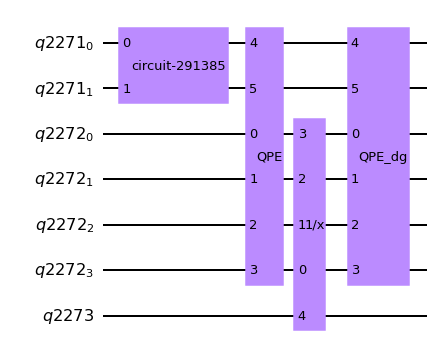

In [44]:
# Create matrix A
dt = 0.1 # time step, unit is in months
T = 6 # period of rotation in months
a = (2*np.pi/T)*dt # the component for our matrix
matrix = np.array([[0,0,1,a],[0,0,-a,1],[1,-a,0,0],[a,1,0,0]]) # our matrix

# Form HHL
vector = np.array([1,0,0,0]) # The HHL().solve() function requires a matrix and vector
# We give the function |00> so that it doesn't add anything to the input qubits

HHL_circuit = HHL().solve(matrix,vector).state #This is the circuit

HHL_circuit.draw()

Now, we'll define a function to solve our solution, it's similar to the one in Task 1, the difference is on the indices that we extract the amplitudes from.

In [45]:
#To run the HHL multiple times, we will define a function to do that for us
def solve_HHL(qc, hhl_circ, num_of_iter, print_circ = False):
    '''
    Explanation for the arguments
    qc: The quantum circuit that initializes our x and y
    hhl_circ: Our HHL circuit
    num_of_iter: Number of iterations, each iteration will add an HHL circuit
    print_circ: If true, it will print the circuit
    '''
    solutions = [] #This variable will contain our solutions
    for i in range(num_of_iter):
        backend = Aer.get_backend('statevector_simulator') # choose the backend
        job_result = execute(qc,backend = backend, shots = 1, memory = False).result()
        solution = job_result.get_statevector(qc).data # Get the statevector
        
        # We want to look at the result from the measurement
        counts = job_result.get_counts() # Get count from classical bits
        meas_bit = list(counts.keys())[0].replace(" ","") # Convert the dictionary to list, get the key (our bits), and remove space in between the bit string

        # We only deal with the real value of the amplitudes
        if i == 0:
            interesting_idx = find_idx("00000",["00","01","10","11"],meas_bit) # Interesting indices for teleportation only
            solutions.append(np.real(solution[interesting_idx])) #We've only initialized the state, so we're concerned with |00000>|input>|alice>
        elif i>0:
            interesting_idx = find_idx("10000",["00","01", "10", "11"],meas_bit) # Interesting indices for teleportation + HHL
            solutions.append(np.real([solution[interesting_idx[2]],solution[interesting_idx[3]],solution[interesting_idx[0]],solution[interesting_idx[1]]])) # We append (x,y,0,0)
        
        if print_circ:
            print(qc)

        qc.barrier() # Draw a barrier
        if i>0:
            qc.x(3) # We apply x gate to flip our state before feeding it to the next HHL gates
            qc.x(8) # We also return the ancilla qubit to zero
        qc = qc.compose(hhl_circ, [2,3,4,5,6,7,8]) # That means we'll match the first qubit of HHL to third qubit of teleportation, second to fourth, etc
        
    return solutions

### Getting the solutions

In [46]:
solutions = solve_HHL(qc,HHL_circuit,15) # Run it for 15 iterations

### Plotting the solutions

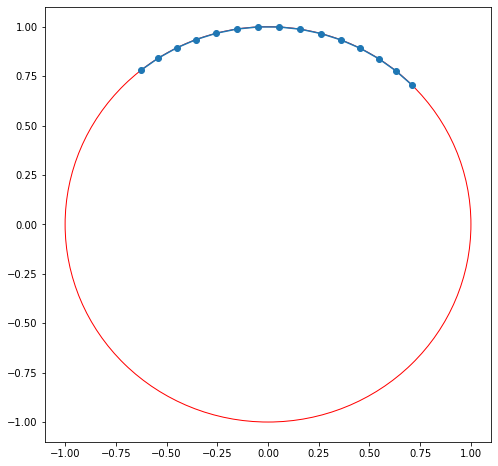

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [47]:
x = [] # store the x values
y = [] # store the y values
for s in solutions: # iterate for each solutions
    x.append(s[0]) # each solution vector has the form (x,y,0,0)
    y.append(s[1]) # we are taking the first two elements
    
    
fig, ax= plt.subplots(figsize=(8,8))

plt.plot(x,y,'-o') # plot the result

circle = plt.Circle((0,0), 1,color = 'r', fill = False) #plot a circle as a comparison
ax.add_patch(circle)
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.show()
plt.plot

Our initial condition is $[\sqrt{1/2},\sqrt{1/2}]$ and as we can see, we did a quarter of a rotation, because $\Delta t = 0.1$ and we did it for 15 iteration. As we can see, the algorithm is successful.